### Model Building

Import Libraries

In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import numpy as np
from statsmodels.graphics import tsaplots as tsa_plots
from statsmodels.tsa.seasonal import seasonal_decompose


Load daily data

In [2]:
daily_data = pd.read_csv("daily_data.csv", parse_dates=True, index_col=0)

Handle missing values (if any)

In [3]:
daily_data = daily_data.dropna()

Standardize the dataset

In [4]:
scaler = StandardScaler()
daily_data_scaled = pd.DataFrame(scaler.fit_transform(daily_data), columns=daily_data.columns, index=daily_data.index)

Check scaled data

In [5]:
print(daily_data_scaled.head())

             PJMW_MW
Datetime            
2002-04-01 -0.448755
2002-04-02 -0.395560
2002-04-03 -0.374549
2002-04-04  0.092945
2002-04-05  0.113730


SARIMA MODEL

Split train and test

In [6]:
# First we split it up between train and test
# We will aim for a 12 month forecast horizon (ie predict the last 12 months in the dataset)
cutoff = '2017-08-04'

daily_data_scaled.sort_index()

train = daily_data_scaled[:cutoff]
test = daily_data_scaled[cutoff:]

In [7]:
train.shape,test.shape

((5605, 1), (365, 1))

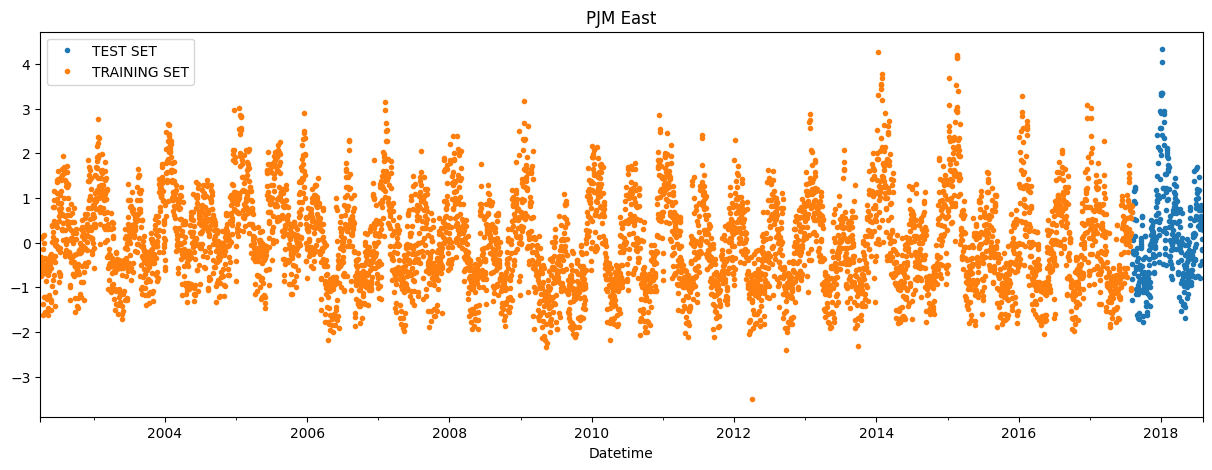

In [8]:
# Plot train and test so you can see where we have split
test.rename(columns={'PJMW_MW': 'TEST SET'}).join(train.rename(columns={'PJMW_MW': 'TRAINING SET'}),
          how='outer').plot(figsize=(15,5), title='PJM East', style='.')
plt.show()

Diff 7

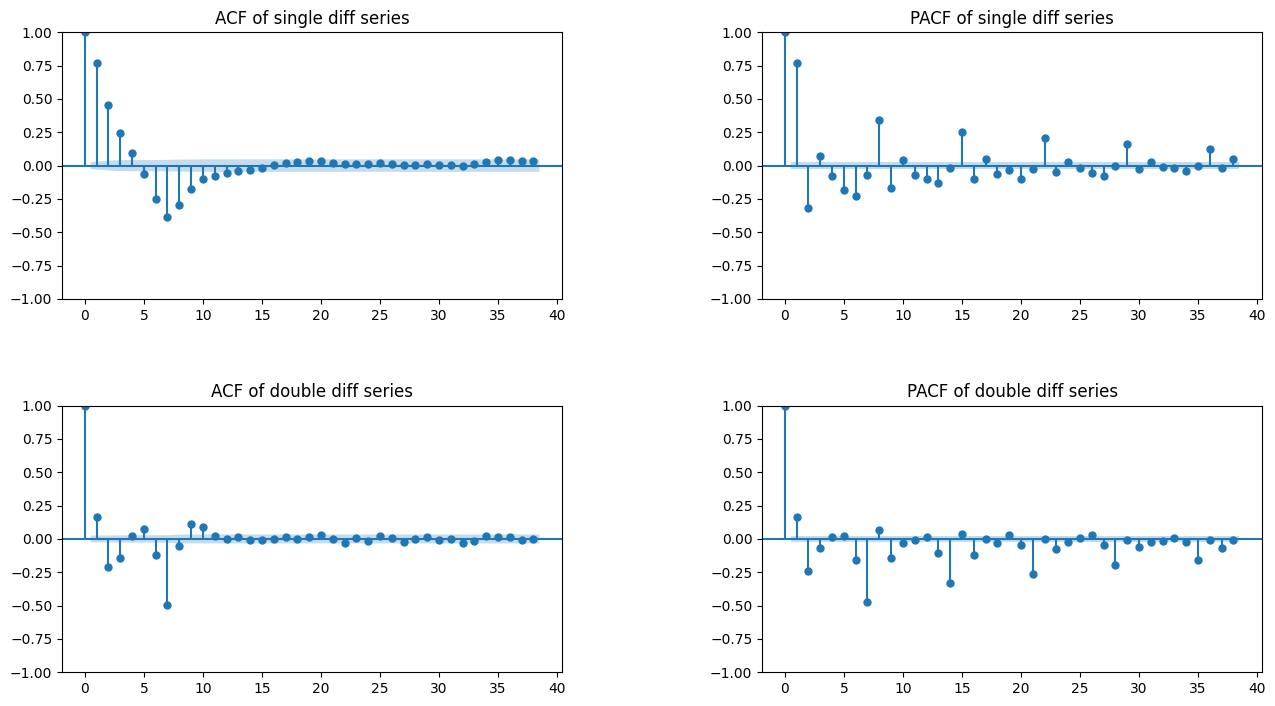

In [9]:
fig,axes = plt.subplots(2,2,figsize=(15,8))
tsa_plots.plot_acf(daily_data_scaled.diff(7).dropna(), ax=axes[0,0]); axes[0,0].set_title('ACF of single diff series')
tsa_plots.plot_pacf(daily_data_scaled.diff(7).dropna(), ax=axes[0,1]); axes[0,1].set_title('PACF of single diff series')

#differencing
tsa_plots.plot_acf(daily_data_scaled.diff(7).diff().dropna(), ax=axes[1,0]); axes[1,0].set_title('ACF of double diff series')
tsa_plots.plot_pacf(daily_data_scaled.diff(7).diff().dropna(), ax=axes[1,1]); axes[1,1].set_title('PACF of double diff series')

plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.4,hspace=0.4)

p=1 q=3 P=1 Q=0

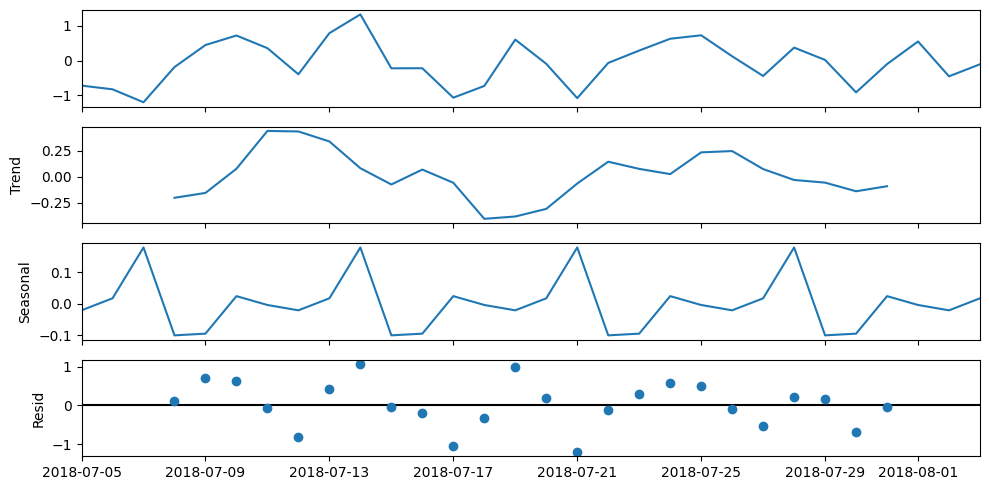

In [10]:
diff7=daily_data_scaled.diff(7).diff().dropna()
plt.rcParams['figure.figsize'] = [10, 5]
decomposition = seasonal_decompose(diff7[-30:], model='additive') # Aggregate to weekly level
decomposition.plot()
plt.show()

In [11]:
model_7=sm.tsa.statespace.SARIMAX(train,order=(1,1,3),seasonal_order=(1,1,0,7))
fitted_7 = model_7.fit(disp=-1)
print(fitted_7.summary())

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimiz

                                     SARIMAX Results                                      
Dep. Variable:                            PJMW_MW   No. Observations:                 5605
Model:             SARIMAX(1, 1, 3)x(1, 1, [], 7)   Log Likelihood               -3340.519
Date:                            Sun, 29 Jun 2025   AIC                           6693.038
Time:                                    06:45:50   BIC                           6732.818
Sample:                                04-01-2002   HQIC                          6706.901
                                     - 08-04-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6302      0.017     37.494      0.000       0.597       0.663
ma.L1         -0.5788      0.190   

In [12]:
n_steps = 365
fc7 = fitted_7.forecast(n_steps,alpha=0.05)

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Model Evaluation

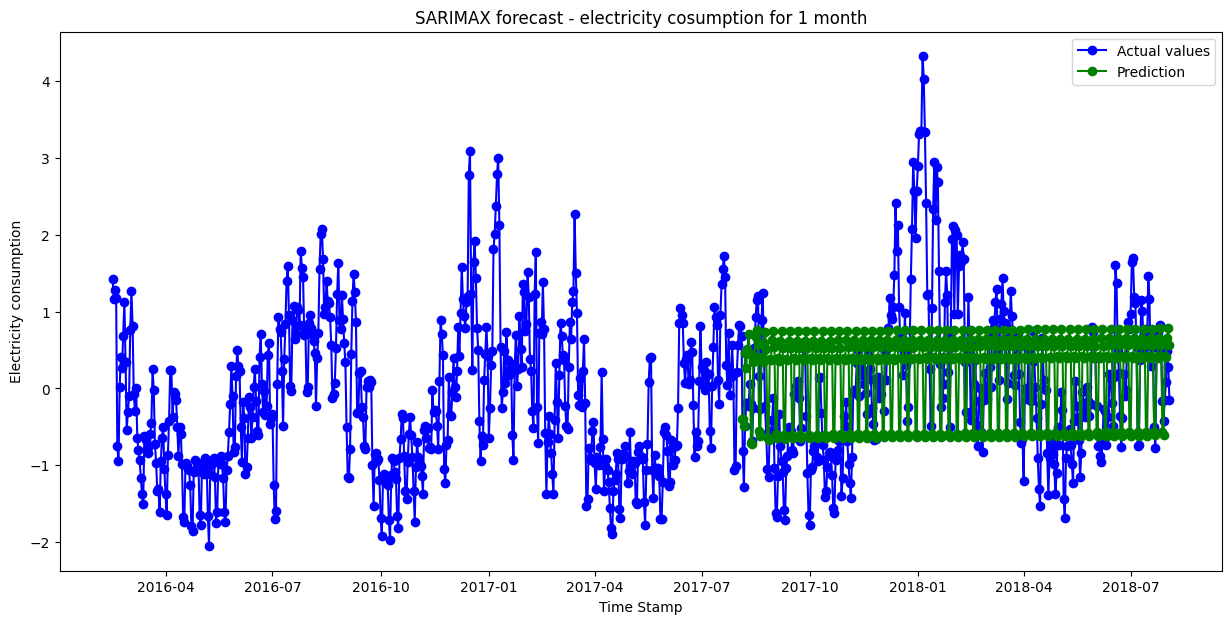

In [13]:
fitted_series7 = pd.Series(fc7,index=test.index)
fitted_series7=fitted_series7.bfill(axis ='rows')
fig, ax = plt.subplots(figsize=(15,7))
# plt.plot(daily_data)
plt.plot(daily_data_scaled[-900:].index,daily_data_scaled[-900:].values, label='Actual values', color="blue", marker="o")
plt.plot(fitted_series7[-365:].index, fitted_series7[-365:].values,label='Prediction', color="green", marker="o")

# plt.plot(fitted_series)

plt.title("SARIMAX forecast - electricity cosumption for 1 month")
plt.xlabel("Time Stamp")
plt.ylabel("Electricity consumption")
plt.legend()

plt.show()

In [14]:
def mape(forecast,actual):
    mape=round(np.mean(np.abs(forecast - actual)/np.abs(actual))*100,2)
    return mape

In [15]:
def mae(forecast,actual):
    mae=round(np.mean(np.abs(forecast - actual)),2)
    return mae

In [16]:
def rmse(forecast,actual):
    rmse = round(np.mean(np.abs(forecast - actual)**2)**.5,2)
    return rmse

In [17]:
MAPE_7= mape(fitted_series7.values, test.values)
MAE_7= mae(fitted_series7.values, test.values)
print("MAPE_7: ",MAPE_7)
print("MAE_7: ",MAE_7)

MAPE_7:  395.22
MAE_7:  0.93


In [18]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse_7=sqrt((mean_squared_error(fitted_series7.values,test.values)))
rmse_7

1.0399341474715904

Diff 30

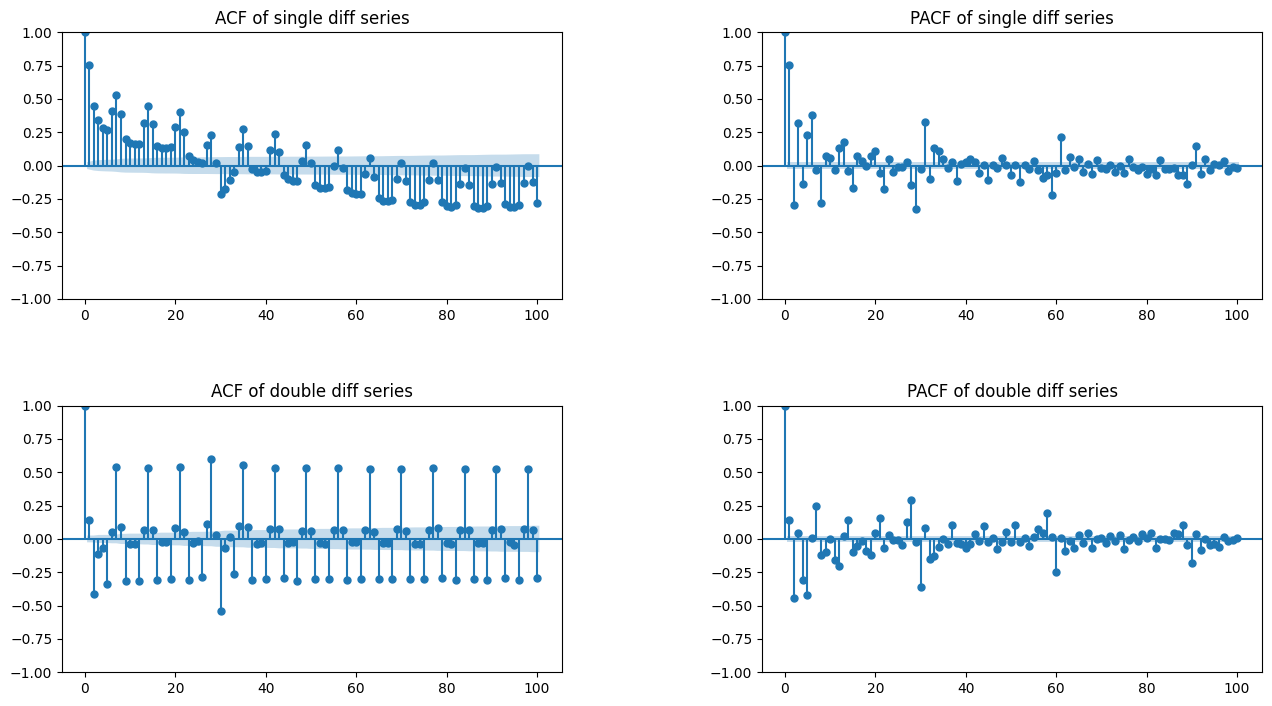

In [19]:
fig,axes = plt.subplots(2,2,figsize=(15,8))
tsa_plots.plot_acf(daily_data_scaled.diff(30).dropna(), ax=axes[0,0],lags=100); axes[0,0].set_title('ACF of single diff series')
tsa_plots.plot_pacf(daily_data_scaled.diff(30).dropna(), ax=axes[0,1],lags=100); axes[0,1].set_title('PACF of single diff series')

#differencing
tsa_plots.plot_acf(daily_data_scaled.diff(30).diff().dropna(), ax=axes[1,0],lags=100); axes[1,0].set_title('ACF of double diff series')
tsa_plots.plot_pacf(daily_data_scaled.diff(30).diff().dropna(), ax=axes[1,1],lags=100); axes[1,1].set_title('PACF of double diff series')

plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.4,hspace=0.4)

Diff 70

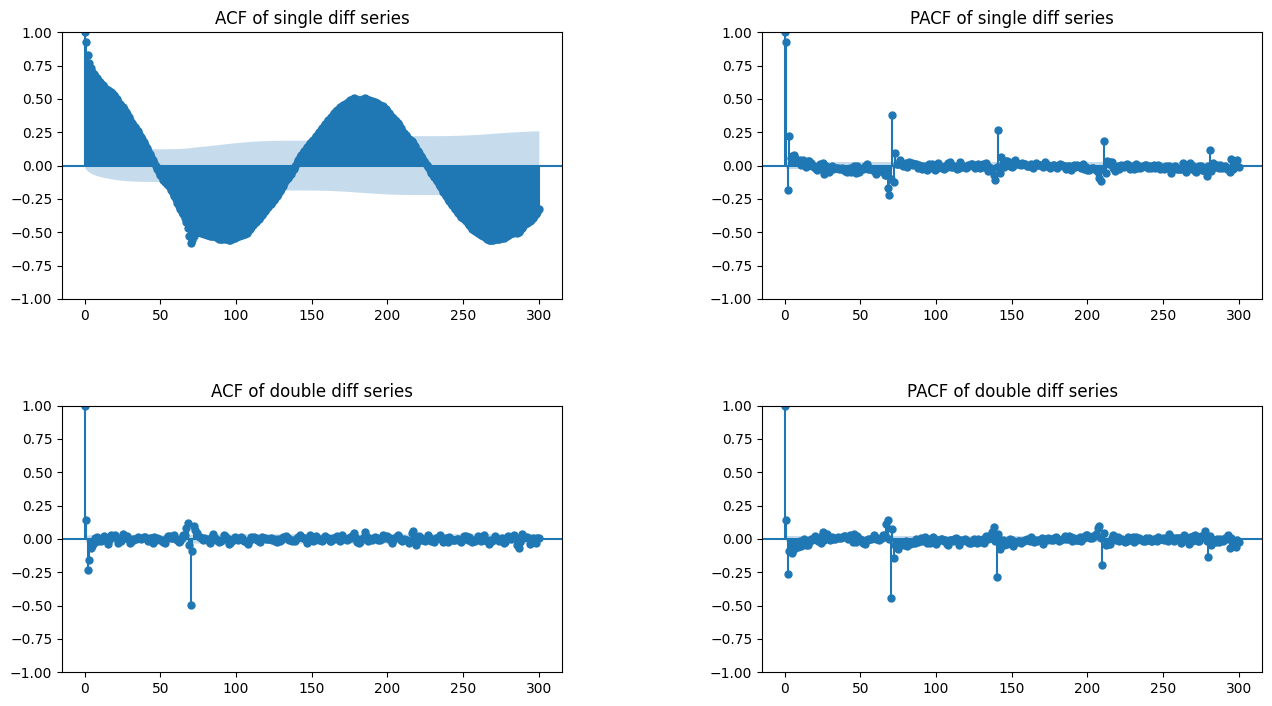

In [20]:
fig,axes = plt.subplots(2,2,figsize=(15,8))
tsa_plots.plot_acf(daily_data_scaled.diff(70).dropna(), ax=axes[0,0],lags=300); axes[0,0].set_title('ACF of single diff series')
tsa_plots.plot_pacf(daily_data_scaled.diff(70).dropna(), ax=axes[0,1],lags=300); axes[0,1].set_title('PACF of single diff series')

#differencing
tsa_plots.plot_acf(daily_data_scaled.diff(70).diff().dropna(), ax=axes[1,0],lags=300); axes[1,0].set_title('ACF of double diff series')
tsa_plots.plot_pacf(daily_data_scaled.diff(70).diff().dropna(), ax=axes[1,1],lags=300); axes[1,1].set_title('PACF of double diff series')

plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.4,hspace=0.4)

In [21]:
data_10year=daily_data_scaled['2008-01-01':'2017-08-03']

In [22]:
data_10year

,PJMW_MW
Datetime,
2008-01-01,0.074420
2008-01-02,1.786644
2008-01-03,2.197600
2008-01-04,1.844932
2008-01-05,0.562190
...,...
2017-07-30,-1.006290
2017-07-31,0.210821
2017-08-01,0.560439


In [23]:
model_70=sm.tsa.statespace.SARIMAX(data_10year,order=(2,1,3),seasonal_order=(1,1,0,70))
fitted_70 = model_70.fit(disp=-1)
print(fitted_70.summary())

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                      
Dep. Variable:                             PJMW_MW   No. Observations:                 3503
Model:             SARIMAX(2, 1, 3)x(1, 1, [], 70)   Log Likelihood               -2354.518
Date:                             Sun, 29 Jun 2025   AIC                           4723.036
Time:                                     06:50:08   BIC                           4766.022
Sample:                                 01-01-2008   HQIC                          4738.393
                                      - 08-03-2017                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3702      0.381      0.970      0.332      -0.378       1.118
ar.L2          0.0495      

In [24]:
n_steps = 365
fc70 = fitted_70.forecast(n_steps,alpha=0.05)

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Evaluvate Model

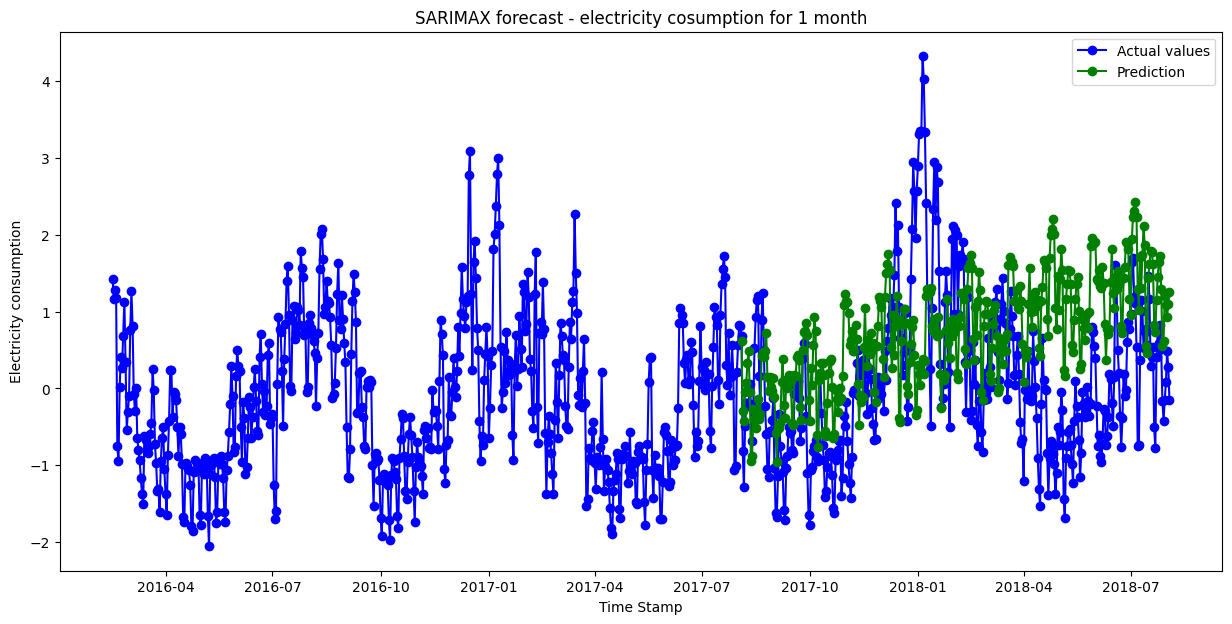

In [25]:
fitted_series70 = pd.Series(fc70,index=test.index)
fitted_series70=fitted_series70.bfill(axis ='rows')
fig, ax = plt.subplots(figsize=(15,7))
# plt.plot(daily_data)
plt.plot(daily_data_scaled[-900:].index,daily_data_scaled[-900:].values, label='Actual values', color="blue", marker="o")
plt.plot(fitted_series70[-365:].index, fitted_series70[-365:].values,label='Prediction', color="green", marker="o")

# plt.plot(fitted_series)

plt.title("SARIMAX forecast - electricity cosumption for 1 month")
plt.xlabel("Time Stamp")
plt.ylabel("Electricity consumption")
plt.legend()

plt.show()

In [26]:
MAPE_70= mape(fitted_series70.values, test.values)
MAE_70= mae(fitted_series70.values, test.values)
print("MAPE_70: ",MAPE_70)
print("MAE_70: ",MAE_70)

MAPE_70:  571.09
MAE_70:  1.13


In [27]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse_70=sqrt((mean_squared_error(fitted_series70.values,test.values)))
rmse_70

1.2635289914324441

Diff 90

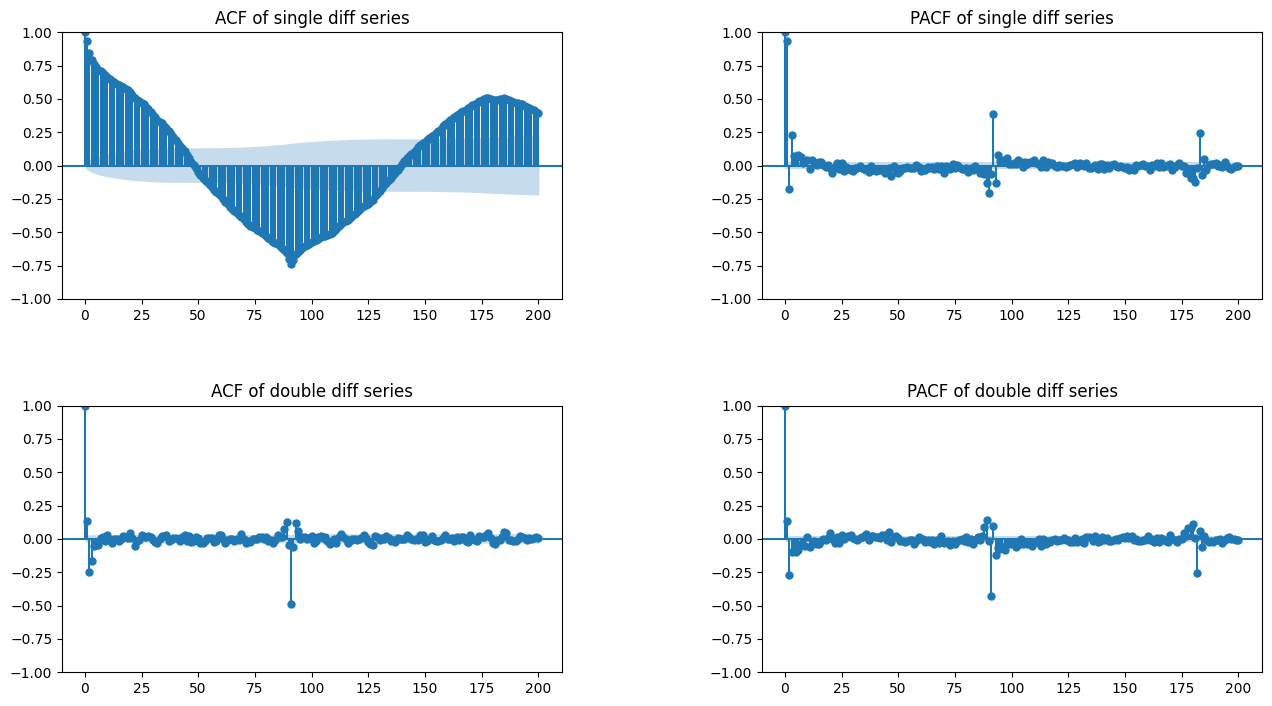

In [28]:
fig,axes = plt.subplots(2,2,figsize=(15,8))
tsa_plots.plot_acf(daily_data_scaled.diff(91).dropna(), ax=axes[0,0],lags=200); axes[0,0].set_title('ACF of single diff series')
tsa_plots.plot_pacf(daily_data_scaled.diff(91).dropna(), ax=axes[0,1],lags=200); axes[0,1].set_title('PACF of single diff series')

#differencing
tsa_plots.plot_acf(daily_data_scaled.diff(91).diff().dropna(), ax=axes[1,0],lags=200); axes[1,0].set_title('ACF of double diff series')
tsa_plots.plot_pacf(daily_data_scaled.diff(91).diff().dropna(), ax=axes[1,1],lags=200); axes[1,1].set_title('PACF of double diff series')

plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.4,hspace=0.4)

p=2,q=3,P=1,q=0

In [29]:
model_90=sm.tsa.statespace.SARIMAX(train,order=(2,1,3),seasonal_order=(1,1,0,91))
fitted_90 = model_90.fit(disp=False,low_memory=True,cov_type='approx')
print(fitted_90.summary())

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                      
Dep. Variable:                             PJMW_MW   No. Observations:                 5605
Model:             SARIMAX(2, 1, 3)x(1, 1, [], 91)   Log Likelihood               -3461.916
Date:                             Sun, 29 Jun 2025   AIC                           6937.832
Time:                                     07:04:48   BIC                           6984.136
Sample:                                 04-01-2002   HQIC                          6953.981
                                      - 08-04-2017                                         
Covariance Type:                            approx                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4321      0.208      2.081      0.037       0.025       0.839
ar.L2          0.0218      

In [30]:
n_steps = 365
fc90 = fitted_90.forecast(n_steps,alpha=0.05)

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Evaluate model

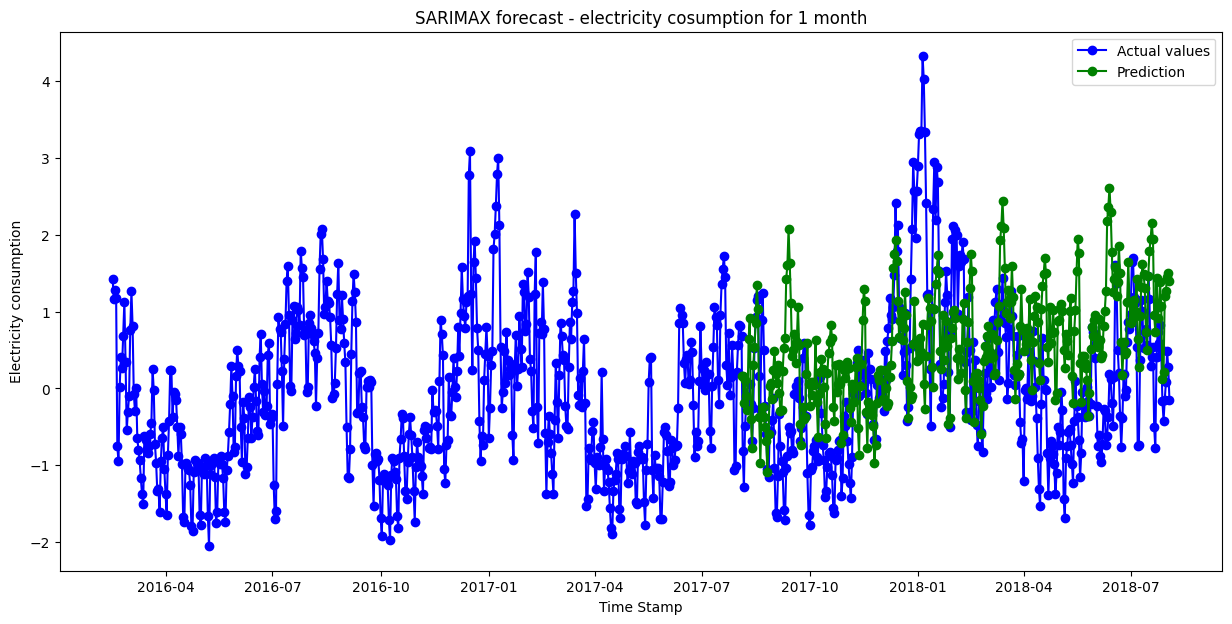

In [31]:
fitted_series90 = pd.Series(fc90,index=test.index)
fitted_series90=fitted_series90.bfill(axis ='rows')
fig, ax = plt.subplots(figsize=(15,7))
# plt.plot(daily_data)
plt.plot(daily_data_scaled[-900:].index,daily_data_scaled[-900:].values, label='Actual values', color="blue", marker="o")
plt.plot(fitted_series90[-365:].index, fitted_series90[-365:].values,label='Prediction', color="green", marker="o")

# plt.plot(fitted_series)

plt.title("SARIMAX forecast - electricity cosumption for 1 month")
plt.xlabel("Time Stamp")
plt.ylabel("Electricity consumption")
plt.legend()

plt.show()

In [32]:
MAPE_90= mape(fitted_series90.values, test.values)
MAE_90= mae(fitted_series90.values, test.values)
print("MAPE_90: ",MAPE_90)
print("MAE_90: ",MAE_90)

MAPE_90:  497.81
MAE_90:  1.06


In [33]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse_90=sqrt((mean_squared_error(fitted_series90.values,test.values)))
rmse_90

1.149643287930975

Diff 120

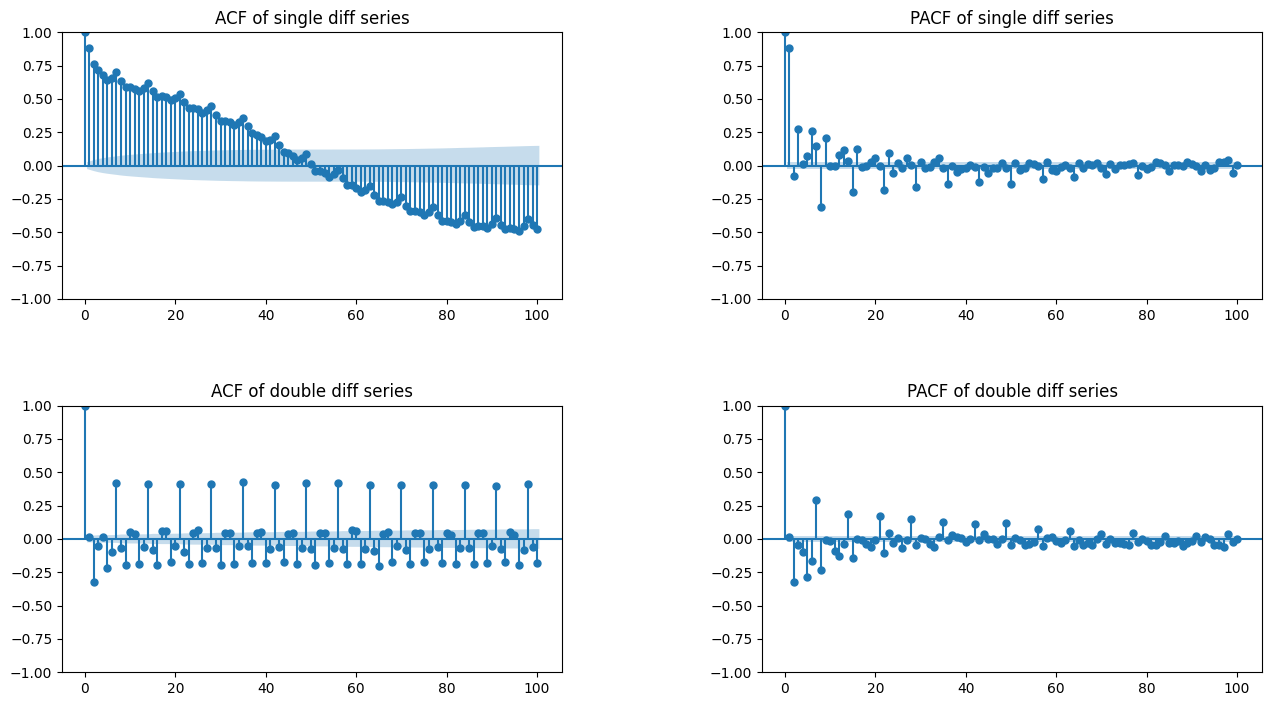

In [34]:
fig,axes = plt.subplots(2,2,figsize=(15,8))
tsa_plots.plot_acf(daily_data_scaled.diff(120).dropna(), ax=axes[0,0],lags=100); axes[0,0].set_title('ACF of single diff series')
tsa_plots.plot_pacf(daily_data_scaled.diff(120).dropna(), ax=axes[0,1],lags=100); axes[0,1].set_title('PACF of single diff series')

#differencing
tsa_plots.plot_acf(daily_data_scaled.diff(120).diff().dropna(), ax=axes[1,0],lags=100); axes[1,0].set_title('ACF of double diff series')
tsa_plots.plot_pacf(daily_data_scaled.diff(120).diff().dropna(), ax=axes[1,1],lags=100); axes[1,1].set_title('PACF of double diff series')

plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.4,hspace=0.4)

In [35]:
daily_data_inversed = pd.DataFrame(
    scaler.inverse_transform(daily_data_scaled),
    columns=daily_data.columns,
    index=daily_data.index
)
daily_data_inversed

,PJMW_MW
Datetime,
2002-04-01,5271.173913
2002-04-02,5310.416667
2002-04-03,5325.916667
2002-04-04,5670.791667
2002-04-05,5686.125000
...,...
2018-07-30,5492.708333
2018-07-31,5660.750000
2018-08-01,5959.708333
